## Gaussian Mixture Models (GMM)

Gordon Richards (2016, 2018)

KDE centers each bin (or kernel rather) at each point.  In a [**mixture model**](https://en.wikipedia.org/wiki/Mixture_model) we don't use a kernel for each data point, but rather we fit for the *locations of the kernels*--in addition to the width.  So a mixture model is sort of a hybrid between a tradtional (fixed bin location/size) histogram and KDE.   Using lots of kernels (maybe even more than the BIC score suggests) may make sense if you just want to provide an accurate description of the data (as in density estimation).  Using fewer kernels makes mixture models more like clustering (later today), where the suggestion is still to use many kernels in order to divide the sample into real clusters and "background".

Gaussians are the most commonly used components for mixture models.  So, the pdf is modeled by a sum of Gaussians:
$$p(x) = \sum_{k=1}^N \alpha_k \mathscr{N}(x|\mu_k,\Sigma_k),$$
where $\alpha_k$ are the "mixing coefficients" with $0\le \alpha_k \le 1$ and $\sum_{k=1}^N \alpha_k = 1$.

We can solve for the parameters using maximum likelihood analyis as we have discussed previously.
However, this can be complicated in multiple dimensions, requiring the use of [**Expectation Maximization (EM)**](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) methods.

### Expectation Maximization (ultra simplified version)

(Note: all explanations of EM are far more complicated than seems necessary for our purposes, so here is my overly simplified explanation.)

This may make more sense in terms of our earlier Bayesian analyses if we write this as 
$$p(z=c) = \alpha_k,$$
and
$$p(x|z=c) = \mathscr{N}(x|\mu_k,\Sigma_k),$$
where $z$ is a "hidden" variable related to which "component" each point is assigned to.

In the Expectation step, we hold $\mu_k, \Sigma_k$, and $\alpha_k$ fixed and compute the probability that each $x_i$ belongs to component, $c$.  

In the Maximization step, we hold the probability of the components fixed and maximize $\mu_k, \Sigma_k,$ and $\alpha_k$.

Note that $\alpha$ is the relative weight of each Gaussian component and not the probability of each point belonging to a specific component.  (Can think of as a 1-D case with 2 Gaussian and 1 background components.)

We can use the following animation to illustrate the process.  

We start with a 2-component GMM, where the initial components can be randomly determined.

The points that are closest to the centroid of a component will be more probable under that distribution in the "E" step and will pull the centroid towards them in the "M" step.  Iteration between the "E" and "M" step eventually leads to convergence.

In this particular example, 3 components better describes the data and similarly converges.  Note that the process is not that sensitive to how the components are first initialized.  We pretty much get the same result in the end.

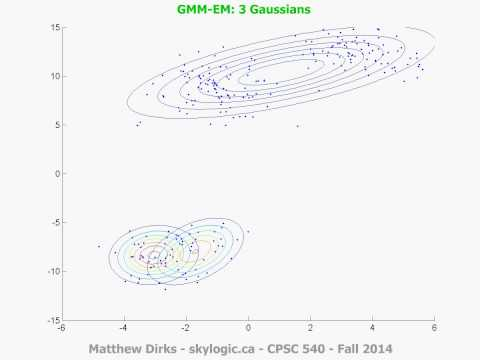

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("B36fzChfyGU")

A typical call to the [Gaussian Mixture Model](http://scikit-learn.org/stable/modules/mixture.html) algorithm looks like this:

In [2]:
# Execute this cell
import numpy as np
from sklearn.mixture import GaussianMixture

X = np.random.normal(size=(1000,2)) #1000  points in 2D
gmm = GaussianMixture(3) #three components
gmm.fit(X)
log_dens = gmm.score(X)
BIC = gmm.bic(X)

Let's start with the 1-D example given using eruption data from "Old Faithful" geyser at Yellowstone National Park.  
[http://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat](http://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat).

In [4]:
#eruptions: Eruption time in mins
#waiting: Waiting time to next eruption
import pandas as pd
df = pd.read_csv('../data/faithful.dat', delim_whitespace=True)
df.head()

,N,eruptions,waiting
0,1,3.600,79
1,2,1.800,54
2,3,3.333,74
3,4,2.283,62
4,5,4.533,85


Make two "fancy" histograms illustrating the distribution of `x=df['eruptions']` and `y=df['waiting']` times.  Use `bins="freedman"` and `histtype="step"`.

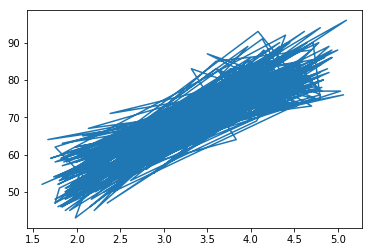

In [12]:
x = df['eruptions']
y = df['waiting']
plt.plot(x,y)

Text(0, 0.5, 'N')

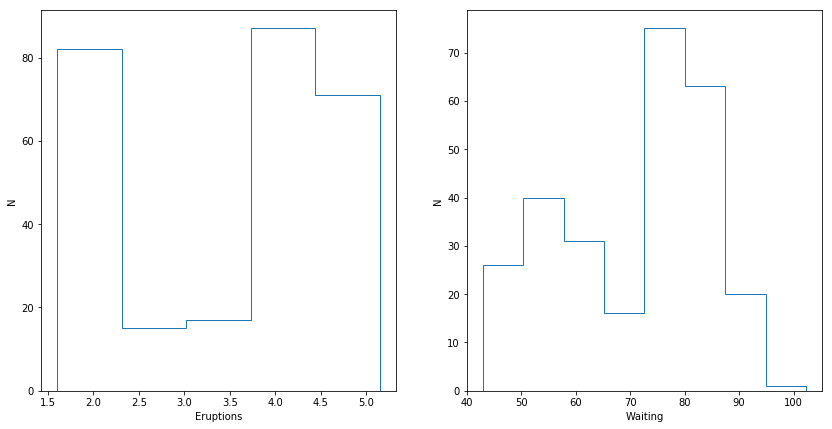

In [13]:
from astroML.plotting import hist as fancyhist
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(121)
fancyhist(df['eruptions'],histtype='step',bins='freedman')
plt.xlabel('Eruptions')
plt.ylabel('N')

ax = fig.add_subplot(122)
fancyhist(df['waiting'],bins='freedman',histtype='step')
plt.xlabel('Waiting')
plt.ylabel('N')

In [26]:
#Fit Gaussian Mixtures, first in 1-D
from sklearn.mixture import GaussianMixture

#First fit Eruptions
gmm1 = GaussianMixture(n_components=2) # 2-component gaussian mixture model
gmm1.fit(df['eruptions'][:,None]) # Fit step
xgrid1 = np.linspace(0, 8, 1000) # Make evaluation grid
logprob1 = gmm1.score_samples(xgrid1[:,None]) # Compute log likelihoods on that grid
pdf1 = np.exp(logprob1)
resp1 = gmm1.predict_proba(xgrid1[:,None]) 
pdf_individual1 = resp1 * pdf1[:, np.newaxis] # Compute posterior probabilities for each component

In [27]:
#Then fit waiting
gmm2 = GaussianMixture(n_components=2)
gmm2.fit(df['waiting'][:,None])
xgrid2 = np.linspace(30, 120, 1000)
logprob2 = gmm2.score_samples(xgrid2[:,None])
pdf2 = np.exp(logprob2)
resp2 = gmm2.predict_proba(xgrid2[:,None])
pdf_individual2 = resp2 * pdf2 [:,None]

Text(0.5, 0, 'Waiting')

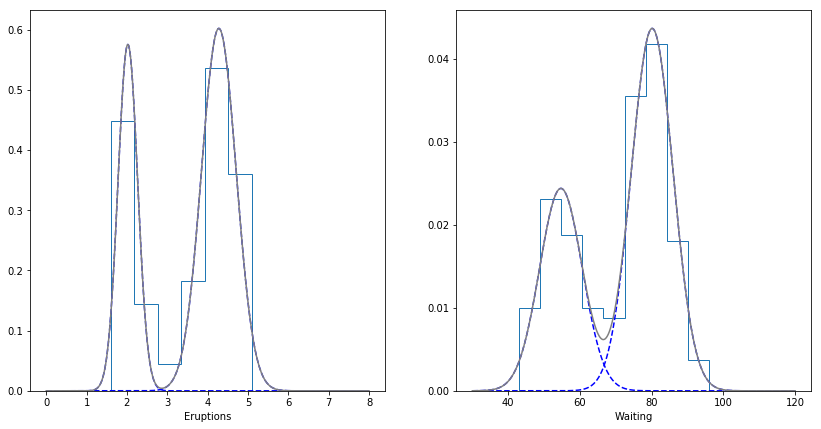

In [29]:
#Make plots
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(121)
plt.hist(df['eruptions'], bins=6, density=True, histtype='step')
plt.plot(xgrid1, pdf_individual1, '--', color='blue')
plt.plot(xgrid1, pdf1, '-', color='gray')
plt.xlabel("Eruptions")

ax = fig.add_subplot(122)
plt.hist(df['waiting'], bins=9, histtype='step', density=True)
plt.plot(xgrid2,pdf_individual2,  '--', color='blue')
plt.plot(xgrid2, pdf2, '-', color='gray')
plt.xlabel("Waiting")

Let's now do a more complicated 1-D example (Ivezic, Figure 6.8), which compares a Mixture Model to KDE.
[Note that the version at astroML.org has some bugs!]

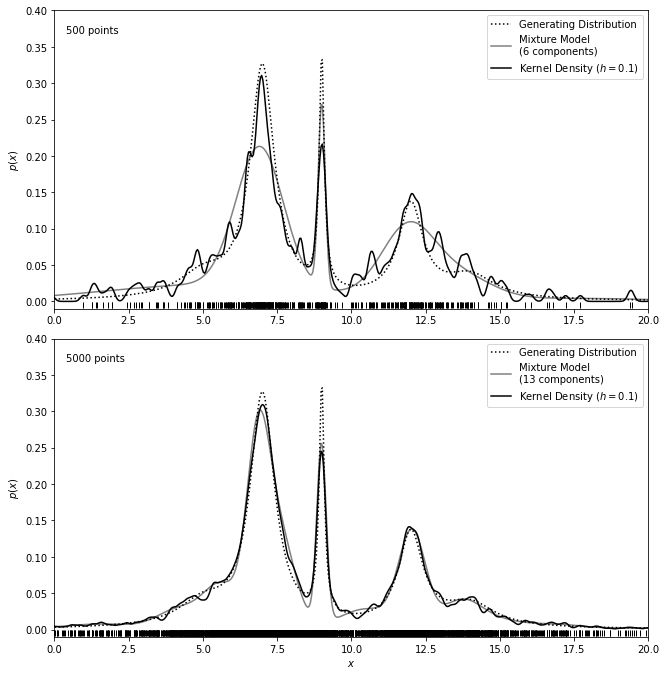

In [30]:
# Execute this cell
# Ivezic, Figure 6.8
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

from astroML.plotting import hist
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity

#------------------------------------------------------------
# Generate our data: a mix of several Cauchy distributions
#  this is the same data used in the Bayesian Blocks figure
np.random.seed(0)
N = 10000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
true_pdf = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x)
                          for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N))
                    for (mu, gamma, f) in mu_gamma_f])
np.random.shuffle(x)
x = x[x > -10]
x = x[x < 30]

#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)
N_values = (500, 5000)
subplots = (211, 212)
k_values = (10, 100)

for N, k, subplot in zip(N_values, k_values, subplots):
    ax = fig.add_subplot(subplot)
    xN = x[:N]
    t = np.linspace(-10, 30, 1000)

    kde = KernelDensity(0.1, kernel='gaussian')
    kde.fit(xN[:, None])
    dens_kde = np.exp(kde.score_samples(t[:, None]))

    # Compute density via Gaussian Mixtures
    # we'll try several numbers of clusters
    n_components = np.arange(3, 16)
    gmms = [GaussianMixture(n_components=n).fit(xN[:,None]) for n in n_components]
    BICs = [gmm.bic(xN[:,None]) for gmm in gmms]
    i_min = np.argmin(BICs)
    t = np.linspace(-10, 30, 1000)
    logprob = gmms[i_min].score_samples(t[:,None])

    # plot the results
    ax.plot(t, true_pdf(t), ':', color='black', zorder=3,
            label="Generating Distribution")
    ax.plot(xN, -0.005 * np.ones(len(xN)), '|k', lw=1.5)
    ax.plot(t, np.exp(logprob), '-', color='gray',
            label="Mixture Model\n(%i components)" % n_components[i_min])
    ax.plot(t, dens_kde, '-', color='black', zorder=3,
            label="Kernel Density $(h=0.1)$")

    # label the plot
    ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
    ax.set_ylabel('$p(x)$')
    ax.legend(loc='upper right')

    if subplot == 212:
        ax.set_xlabel('$x$')

    ax.set_xlim(0, 20)
    ax.set_ylim(-0.01, 0.4001)

plt.show()

Let's plot the BIC values and see why it picked that many components.

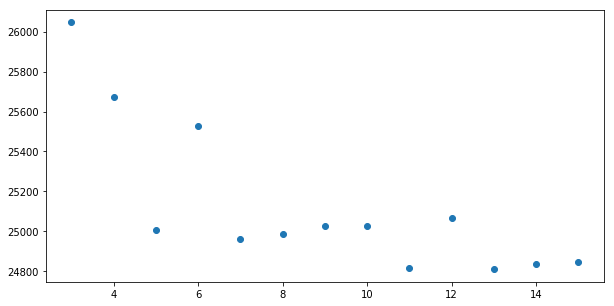

In [31]:
fig = plt.figure(figsize=(10, 5))
plt.scatter(n_components,BICs)
plt.show()

What do the individual components look like?  Make a plot of those.  Careful with the shapes of the arrays!

13


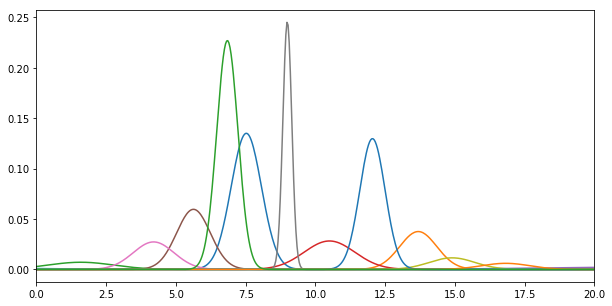

In [32]:
# See Ivezic, Figure 4.2 for help: http://www.astroml.org/book_figures/chapter4/fig_GMM_1D.html
fig = plt.figure(figsize=(10, 5))
print(len(gmms[10].weights_))
logprob =  gmms[10].score_samples(t[:,None])
pdf = np.exp(logprob) # Sum of the individual component pdf
resp = gmms[10].predict_proba(t[:,None]) # Array of "responsibilities" for each component
plt.plot(t,resp*pdf[:,None])
plt.xlim((0,20))
plt.show()

Now let's look at the Old Faithful data again, but this time in 2-D.

(40, 100)

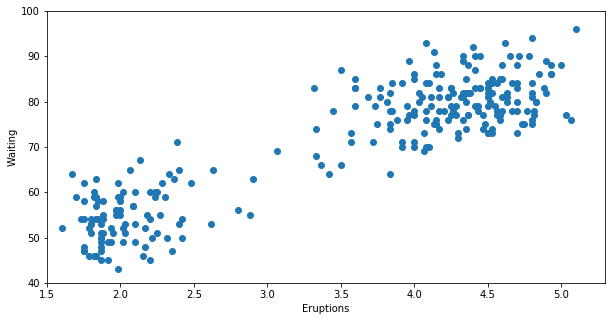

In [33]:
fig = plt.figure(figsize=(10, 5))
plt.scatter(df['eruptions'],df['waiting'])
plt.xlabel('Eruptions')
plt.ylabel('Waiting')
plt.xlim([1.5,5.3])
plt.ylim([40,100])

Now we'll fit both features at the same time (i.e., the $x$ and $y$ axes above).  Note that Scikit-Learn can handle Pandas DataFrames without further conversion.

In [34]:
gmm3 = GaussianMixture(n_components=2)
gmm3.fit(df[['eruptions','waiting']])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

Once the components have been fit, we can plot the location of the centroids and the "error" ellipses.

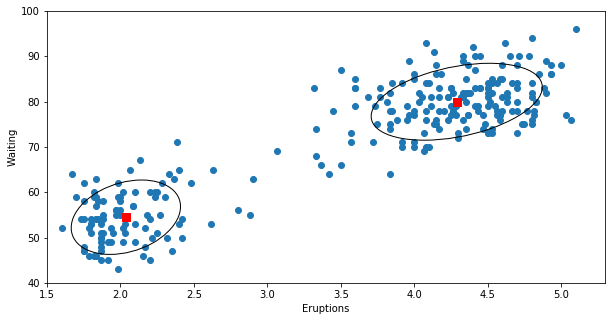

In [36]:
from astroML.plotting.tools import draw_ellipse
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
plt.scatter(df['eruptions'],df['waiting'])
plt.xlabel('Eruptions')
plt.ylabel('Waiting')
plt.xlim([1.5,5.3])
plt.ylim([40,100])

ax.scatter(gmm3.means_[:,0], gmm3.means_[:,1], marker='s', c='red', s=80)
for mu, C, w in zip(gmm3.means_, gmm3.covariances_, gmm3.weights_):
    draw_ellipse(mu, 2*C, scales=[1], ax=ax, fc='none', ec='k') #2 sigma ellipses for each component

Ivezic, Figure 6.6 shows another 2-D example.  In the first panel, we have the raw data.  In the second panel we have a density plot (essentially a 2-D histogram).  We then try to represent the data with a series of Gaussians.  We allow up to 14 Gaussians and use the AIC/BIC to determine the best choice for this number.  This is shown in the third panel.  Finally, the fourth panel shows the chosen Gaussians with their centroids and 1-$\sigma$ contours.

In this case 7 components are required for the best fit.  While it looks like we could do a pretty good job with just 2 components, there does appear to be some "background" that is a high enough level to justify further components.

In [38]:
# Execute this cell
# Ivezic, Figure 6.6
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

#from sklearn.mixture import GMM
from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture

from astroML.datasets import fetch_sdss_sspp
from astroML.decorators import pickle_results
from astroML.plotting.tools import draw_ellipse

#------------------------------------------------------------
# Get the Segue Stellar Parameters Pipeline data
data = fetch_sdss_sspp(cleaned=True)

# Note how X was created from two columns of data
X = np.vstack([data['FeH'], data['alphFe']]).T

# truncate dataset for speed
X = X[::5]

#------------------------------------------------------------
# Compute GMM models & AIC/BIC
N = np.arange(1, 14)

#@pickle_results("GMM_metallicity.pkl")
def compute_GMM(N, covariance_type='full', n_iter=1000):
    models = [None for n in N]
    for i in range(len(N)):
        #print N[i]
        models[i] = GMM(n_components=N[i], n_iter=n_iter, covariance_type=covariance_type)
        #models[i] = GaussianMixture(n_components=N[i], max_iter=n_iter, covariance_type=covariance_type)
        models[i].fit(X)
    return models

models = compute_GMM(N)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

i_best = np.argmin(BIC)
gmm_best = models[i_best]
print("best fit converged:", gmm_best.converged_)
print("BIC: n_components =  %i" % N[i_best])

#------------------------------------------------------------
# compute 2D density
FeH_bins = 51
alphFe_bins = 51
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'], (FeH_bins, alphFe_bins))

Xgrid = np.array(map(np.ravel,
                     np.meshgrid(0.5 * (FeH_bins[:-1]
                                        + FeH_bins[1:]),
                                 0.5 * (alphFe_bins[:-1]
                                        + alphFe_bins[1:])))).T
log_dens = gmm_best.score(Xgrid).reshape((51, 51))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(12, 5))
fig.subplots_adjust(wspace=0.45, bottom=0.25, top=0.9, left=0.1, right=0.97)

# plot data
ax = fig.add_subplot(141)
ax.scatter(data['FeH'][::10],data['alphFe'][::10],marker=".",color='k',edgecolors='None')
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.text(0.93, 0.93, "Input",
        va='top', ha='right', transform=ax.transAxes)

# plot density
ax = fig.add_subplot(142)
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.text(0.93, 0.93, "Density",
        va='top', ha='right', transform=ax.transAxes)

# plot AIC/BIC
ax = fig.add_subplot(143)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, ':k', label='BIC')
ax.legend(loc=1)
ax.set_xlabel('N components')
plt.setp(ax.get_yticklabels(), fontsize=7)

# plot best configurations for AIC and BIC
ax = fig.add_subplot(144)
ax.imshow(np.exp(log_dens),
          origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

ax.scatter(gmm_best.means_[:, 0], gmm_best.means_[:, 1], c='w')
for mu, C, w in zip(gmm_best.means_, gmm_best.covars_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[1], ax=ax, fc='none', ec='k')

ax.text(0.93, 0.93, "Converged",
        va='top', ha='right', transform=ax.transAxes)

ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

plt.show()

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

best fit converged: True
BIC: n_components =  7


TypeError: float() argument must be a string or a number, not 'map'

That said, I'd say that there are *too* many components here.  So, I'd be inclined to explore this a bit further if it were my data.

Talk about how to use this to do outlier finding.  Convolve with errors of unknown object.

Lastly, let's look at a 2-D case where we are using GMM more to characterize the data than to find clusters.  

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

converged: True


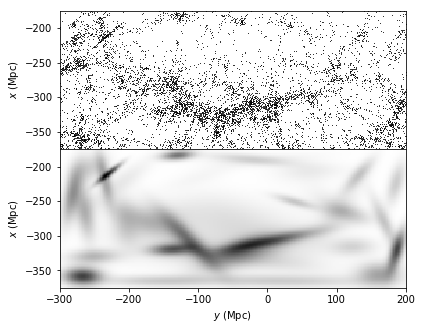

In [40]:
# Execute this cell
# Ivezic, Figure 6.7
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from sklearn.mixture import GMM
from astroML.datasets import fetch_great_wall
from astroML.decorators import pickle_results

#------------------------------------------------------------
# load great wall data
X = fetch_great_wall()

#------------------------------------------------------------
# Create a function which will save the results to a pickle file
#  for large number of clusters, computation will take a long time!
#@pickle_results('great_wall_GMM.pkl')
def compute_GMM(n_clusters, n_iter=1000, min_covar=3, covariance_type='full'):
    clf = GMM(n_clusters, covariance_type=covariance_type,
              n_iter=n_iter, min_covar=min_covar)
    clf.fit(X)
    print("converged:", clf.converged_)
    return clf

#------------------------------------------------------------
# Compute a grid on which to evaluate the result
Nx = 100
Ny = 250
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

#------------------------------------------------------------
# Compute the results
#
# we'll use 100 clusters.  In practice, one should cross-validate
# with AIC and BIC to settle on the correct number of clusters.
clf = compute_GMM(n_clusters=100)
log_dens = clf.score(Xgrid).reshape(Ny, Nx)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(hspace=0, left=0.08, right=0.95, bottom=0.13, top=0.9)

ax = fig.add_subplot(211, aspect='equal')
ax.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)

ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.ylabel(r'$x\ {\rm (Mpc)}$')

ax = fig.add_subplot(212, aspect='equal')
ax.imshow(np.exp(log_dens.T), origin='lower', cmap=plt.cm.binary,
          extent=[ymin, ymax, xmin, xmax])
ax.set_xlabel(r'$y\ {\rm (Mpc)}$')
ax.set_ylabel(r'$x\ {\rm (Mpc)}$')

plt.show()

Note that this is very different than the non-parametric density estimates that we did last time in that the GMM isn't doing that great of a job of matching the distribution.  However, the advantage is that we now have a *model*.  This model can be stored very compactly with just a few numbers, unlike the KDE or KNN maps which require a floating point number for each grid point.  

One thing that you might imagine doing with this is subtracting the model from the data and looking for interesting things among the residuals.